In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, LSTM
import warnings
warnings.filterwarnings('ignore')


In [6]:
# Load the dataset

from google.colab import files
uploaded = files.upload()

file_path = "CPT_II_ConnersContinuousPerformanceTest.csv"
df = pd.read_csv(file_path, delimiter=';')
df.head()

Saving CPT_II_ConnersContinuousPerformanceTest.csv to CPT_II_ConnersContinuousPerformanceTest.csv


,ID,Assessment Status,Assessment Duration,Type,LastTrial,Trial1,Response1,Trial2,Response2,Trial3,...,Raw Score HitRTIsi,Percent HitRTIsi,General TScore HitSEIsi,Adhd TScore HitSEIsi,Neuro TScore HitSEIsi,Raw Score HitSEIsi,Percent HitSEIsi,Adhd Confidence Index,Neuro Confidence Index,Old Overall Index
0,2,3,839999,6,360,11,-1,13,469,7,...,0.049592,0,48.021103,47.772537,43.224297,-0.021096,0,61.145496,58.749630,10.070000
1,3,3,839999,6,360,12,-1,0,371,2,...,0.064090,0,42.234097,38.263283,41.574574,-0.077351,0,86.871597,61.088688,4.440000
2,4,3,839999,6,360,14,-1,10,-1,3,...,0.077233,0,45.680782,42.289310,43.868061,-0.046142,0,99.900002,86.131813,18.340000
3,5,3,839999,6,360,12,459,7,289,12,...,0.085540,0,85.698700,70.469986,80.228539,0.410634,0,99.900002,99.900002,8.950001
4,7,3,839998,6,360,11,841,7,-1,5,...,0.024632,0,42.058998,43.349667,39.992119,-0.071200,0,32.291084,24.225414,0.000000


In [9]:
df.isna().sum()

,0
ID,0
Assessment Status,0
Assessment Duration,0
Type,0
LastTrial,0
...,...
Raw Score HitSEIsi,0
Percent HitSEIsi,0
Adhd Confidence Index,0
Neuro Confidence Index,0


In [ ]:
df.isna().sum().sum()

np.int64(0)

In [10]:
# Define target variable (ADHD Confidence Index as binary classification)
df['ADHD_Diagnosis'] = (df['Adhd Confidence Index'] > 50).astype(int)  # 1 = ADHD, 0 = No ADHD



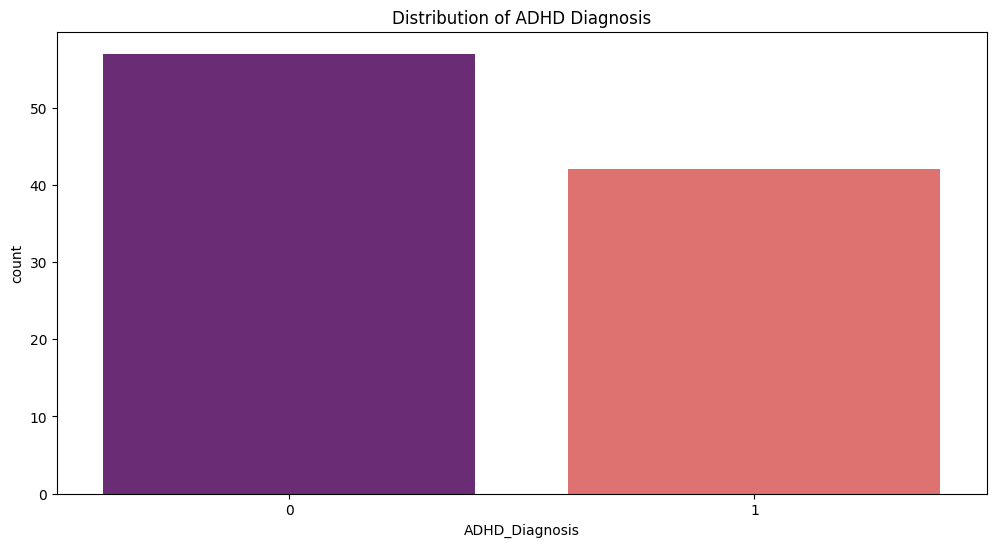

In [11]:
# Exploratory Data Analysis
plt.figure(figsize=(12,6))
sns.countplot(x='ADHD_Diagnosis', data=df, palette='magma')
plt.title('Distribution of ADHD Diagnosis')
plt.show()


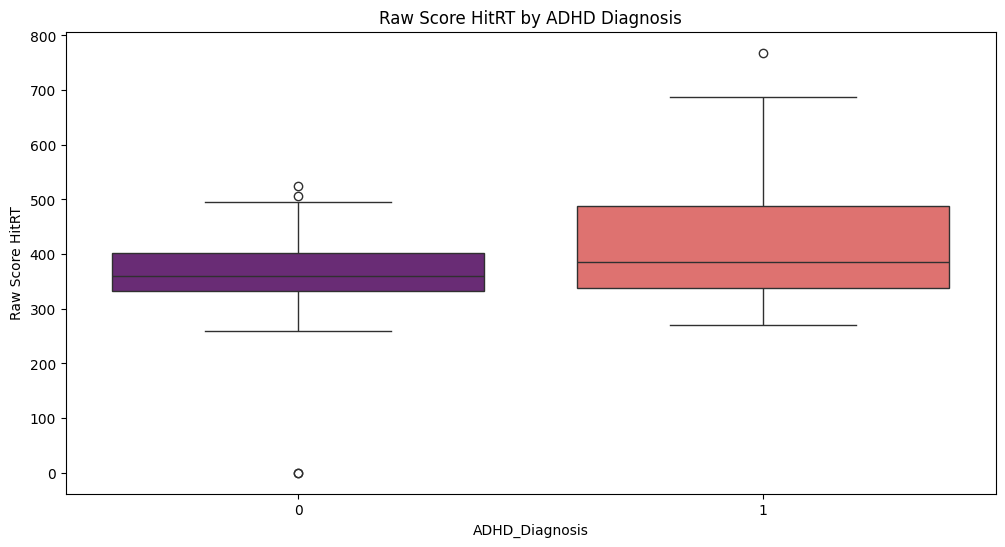

In [12]:
plt.figure(figsize=(12,6))
sns.boxplot(x='ADHD_Diagnosis', y=df['Raw Score HitRT'], data=df, palette='magma')
plt.title('Raw Score HitRT by ADHD Diagnosis')
plt.show()


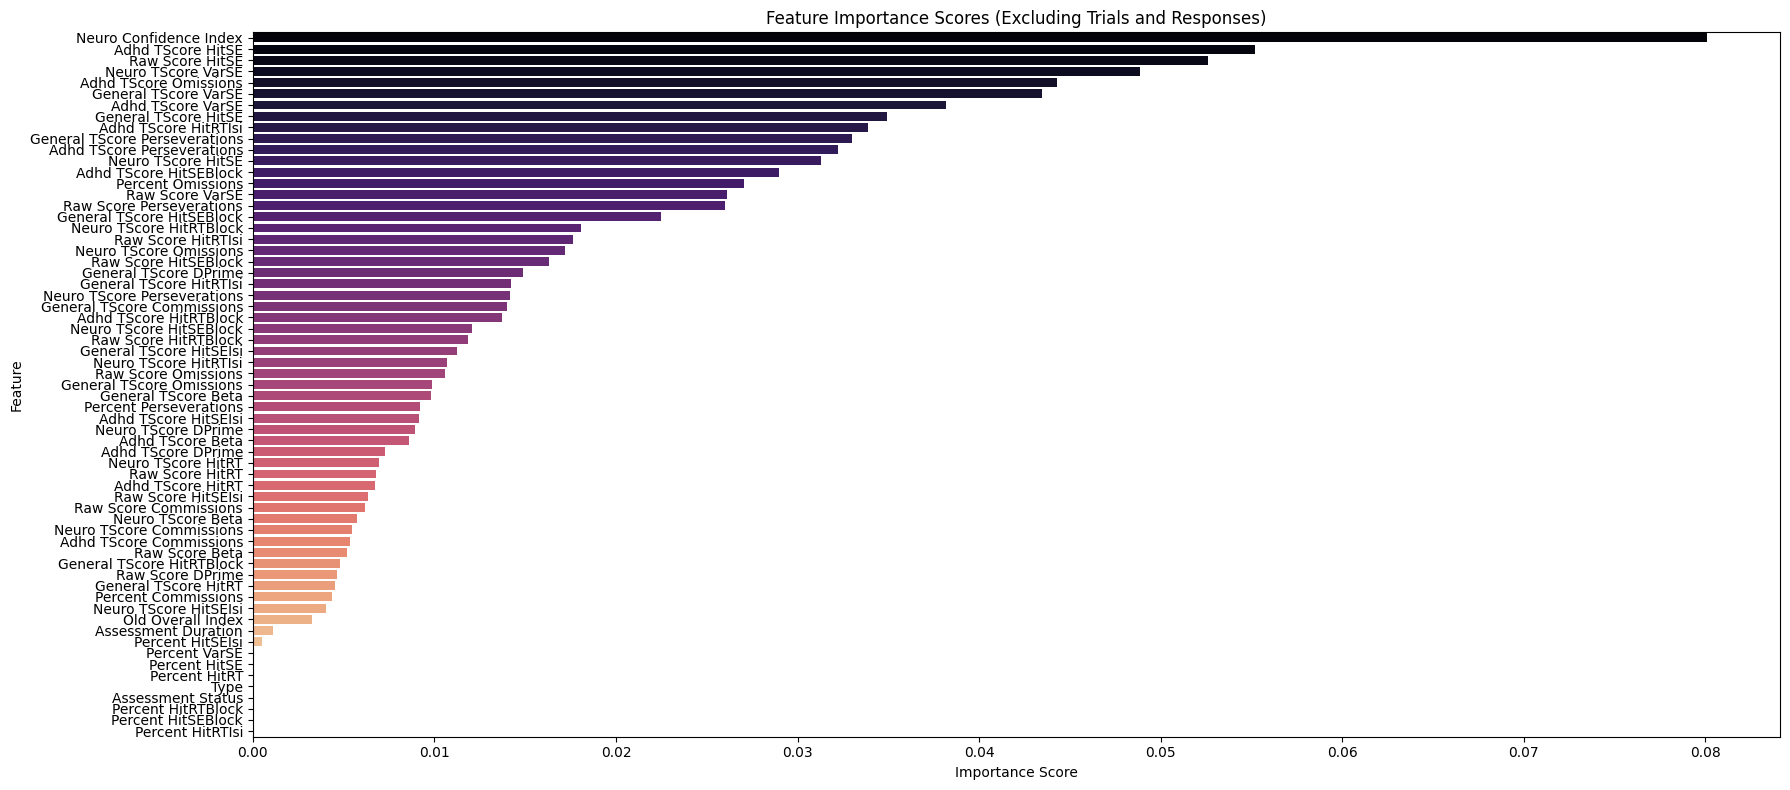

In [18]:
# Drop Trial and Response columns
columns_to_exclude = [col for col in df.columns if 'Trial' in col or 'Response' in col]

# Now drop non-relevant + Trial/Response columns
features_to_drop = ['ID', 'ADHD_Diagnosis', 'Adhd Confidence Index'] + columns_to_exclude
X = df.drop(columns=features_to_drop, errors='ignore')
y = df['ADHD_Diagnosis']

# Feature Importance using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot (Horizontal Bar Chart without Trial/Response columns)
plt.figure(figsize=(18, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='magma')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance Scores (Excluding Trials and Responses)")
plt.tight_layout()
plt.show()


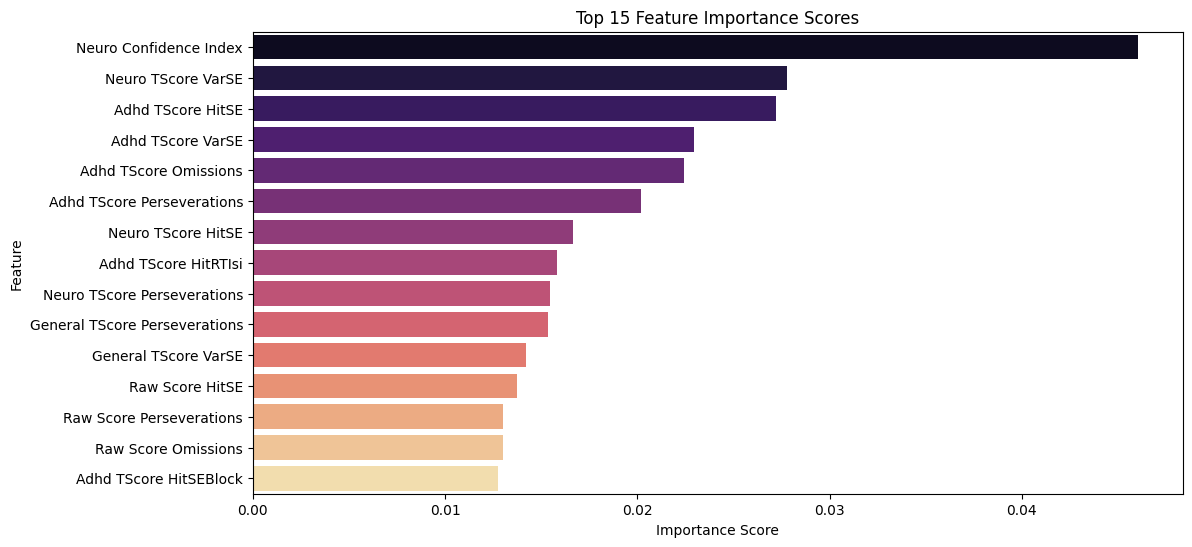

In [19]:
# Drop non-relevant columns (ID and categorical variables if any)
features_to_drop = ['ID', 'ADHD_Diagnosis', 'Adhd Confidence Index']
X = df.drop(columns=features_to_drop, errors='ignore')
y = df['ADHD_Diagnosis']

# Feature Selection using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False).head(15)
selected_features = feature_importances['Feature'].tolist()

# Keep only the top 15 most important features
X = X[selected_features]

# Plot Feature Importance
plt.figure(figsize=(12,6))
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'], palette='magma')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 15 Feature Importance Scores")
plt.show()

In [ ]:
selected_features

['Neuro Confidence Index',
 'Neuro TScore VarSE',
 'Adhd TScore HitSE',
 'Adhd TScore VarSE',
 'Adhd TScore Omissions',
 'Adhd TScore Perseverations',
 'Neuro TScore HitSE',
 'Adhd TScore HitRTIsi',
 'Neuro TScore Perseverations',
 'General TScore Perseverations',
 'General TScore VarSE',
 'Raw Score HitSE',
 'Raw Score Perseverations',
 'Raw Score Omissions',
 'Adhd TScore HitSEBlock']

In [ ]:
df_combined = pd.concat([X, y], axis=1)
df_combined.head()

,Neuro Confidence Index,Neuro TScore VarSE,Adhd TScore HitSE,Adhd TScore VarSE,Adhd TScore Omissions,Adhd TScore Perseverations,Neuro TScore HitSE,Adhd TScore HitRTIsi,Neuro TScore Perseverations,General TScore Perseverations,General TScore VarSE,Raw Score HitSE,Raw Score Perseverations,Raw Score Omissions,Adhd TScore HitSEBlock,ADHD_Diagnosis
0,58.749630,47.313202,52.266724,56.680264,48.617069,45.960991,46.328171,44.764221,44.977715,45.910095,63.262173,7.099574,0,5,73.413300,1
1,61.088688,44.698776,49.884254,52.487644,70.258568,77.101982,43.217041,53.880283,49.628159,151.525207,55.966831,5.512853,5,11,56.108963,1
2,86.131813,44.092140,73.548889,51.577404,81.135651,64.040787,50.403320,57.213779,48.388687,109.223038,54.914539,8.852735,3,15,53.179558,1
3,99.900002,71.502686,57.789284,67.443703,50.876575,60.982868,56.714081,51.601707,64.221878,95.529411,83.324196,11.575007,8,10,72.043434,1
4,24.225414,39.814167,43.678928,42.459812,45.635860,45.960991,40.733135,38.070797,44.977715,45.910095,47.997269,5.002260,0,1,49.865376,0


In [ ]:
df=df_combined.copy()

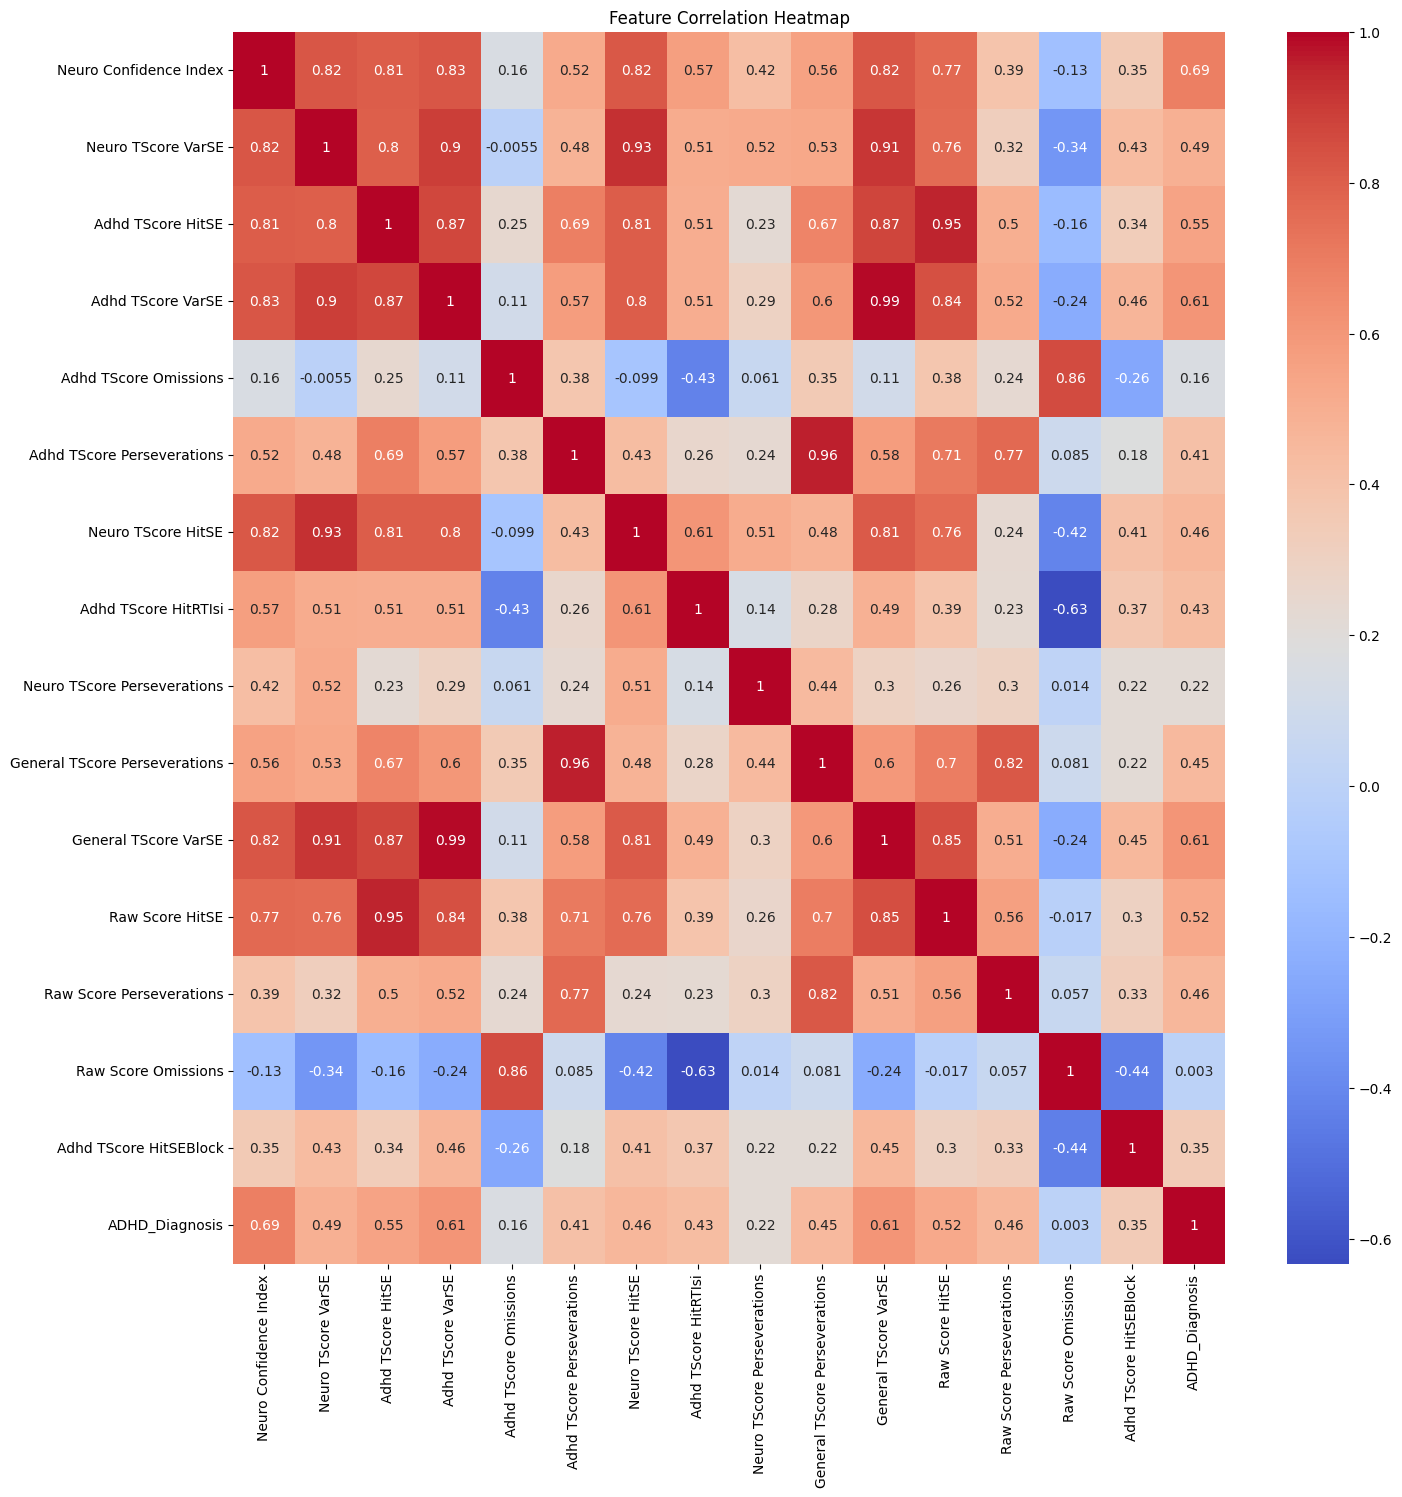

In [ ]:
# Feature Correlation Heatmap
plt.figure(figsize=(16,16))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True)
plt.title('Feature Correlation Heatmap')
plt.show()